## PyTorch: A simple two layer fully connected network

Here we will go step by step through implmenting a very simple 2 layer fully connected network to label MNIST digits.

We start with a number of extra imports: pyplot lets us create plots, torch.nn is a torch library for implementing neural nets, and transforms is a torchvision package to help us work with image data, and datasets is a torchvision package granting us access to some built in test data. We will look at importing data in a later example.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from timeit import default_timer as timer

transforms.Compose() is a torchvision function that allows multiple image transformations to be chained together (ex. flipping, resizing, etc).  
Here, Compose() is used to chain transformations of converting to a tensor and normalizing the pixel values.   

ToTensor() converts an image to a PyTorch tensor and scales pixel values from 0,255 to 0,1  
Normalize(u, o) normalizes the tensor with equation (X-u)/o where u= mean and o= standard deviation

In [2]:
# normalize the pixel values to [-1,1] with mean 0.
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))])

#MNIST is a built-in dataset included with PyTorch
training_data = dsets.MNIST(root="./data", train = True, transform=transform, download = True)

We should have a **validation set** of data as well, but the built in MNIST caller does not support a validation set, and we will just use the testing data set as the validation set for purpose of this tutorial.

In [3]:
testing_data = dsets.MNIST(root="./data", train = False, transform=transform, download = True)

torch.Size([1, 28, 28])


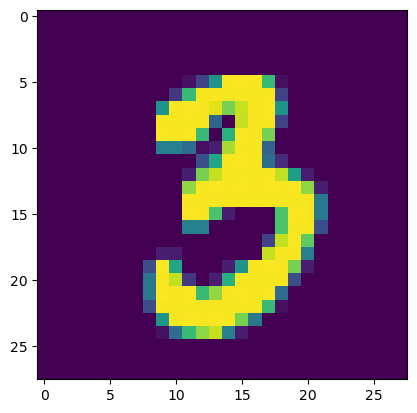

In [5]:
## The mnist data comes in as a tuple. The first index is the pixel values packed in a pytorch Tensor, 
## the 2nd index is the class label.
# To show the image I have to make pytorch tensor a 
# seleccting the data (the pixel values) of the 891st image in the training dataset
training_image_tensor = training_data[890][0]

# Note that the image is a 1x28x28 tensor: there is only one color channel; it is grayscale. 
print(training_image_tensor.shape)
plt.imshow(training_image_tensor[0])

# note: if kernel keeps dying at this cell, check numpy version compatibility

In [6]:
class_label = training_data[890][1]
print(class_label)

3


PyTorch comes with **built-in DataLoaders** that make it trivial to create minibatches and to enumerate over them. Always use these helpers!!

A DataLoader takes as input the desired minibatch size you would like (batch_size), and whether or not you would like the data to be shuffled before it is partitioned into minibatches. No shuffling means the exact same minibatches will be presented to your network every epoch. There is not a lot of guidance as to whether shuffling is good or bad, but intuition says shuffling should help with generalizability a bit.

The DataLoader function returns an *iterator* over your datasets with shuffling and batchsize specified.

In [7]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing_data, batch_size=len(testing_data), shuffle=False)

len(train_loader)

# note: the batch size is the number of batches, not the number of samples per batch. 1/64th of the dataset
# is the length returned by train_loader. 

938

## Setting up a deep net
### 1. Specify and instantiate the network.

Here we go. A DNN is specified as a class that inherets from nn.Module. They all have the same structure:  
1. a call to the constructor of nn.Module (super)
2. specification of a number of network layers. It is common practice to wrap the way the nodes are wired and the activation function (and any other processing, like doing batch norm) inside of an nn.Sequential object. nn.Sequential is just a convinent wrapper of a number of nn.function calls. 
3. Definition of a **forward** function. This function must be specified. This function describes the way that data will pass through your deep net. Here, we see that the input will bass through fc1, then fc2, and we return thr output of fc2.   
        
A few things to note:   
1. We do not need to tell the deep net what the size of the minibatch we will present to it is.
2. nn.Linear specifies a linear combination of inputs into a layer. The linear combination is the $ \sum_{i=1}^{n} w_i x_i$ we are used to seeing, where the summation is over **every node in the previous layer**. So nn.Linear specifies a fully-connected connectivity in this layer. 
3. We simply output the ReLU activation values of fc2 -- we do not normalize these values so they sum to 1. We may want to do a normalization here if we want the network to output a score for the likelihood the input is of each class that looks like a probability. We could do so by specifiying a **softmax** layer. But this is equivalent to just predicting the class corresponding to the fc2 output that is maximum.  
    

**The PyTorch docs are a great place to see what types of layers and activations are implemented**. Of course, nothing is stoping you from implementing your own layer or activation function and then call those functions inside of the deep net specification.  


The nn.Module class establishes automatic gradient calculation, layer initialization, and module registration, among other features. It is the base class for all nueral network modules in PyTorch.  

The nn.Sequential class is the container module that allows NN layers to be stacked in sequential order. PyTorch automatically calculates the forward pass when Sequential is used.   

nn.Linear defines a layer with a linear transformation: y = wx + b, where w is weight matrix, x is input vector, y is output vector, and b is bias term

In [9]:
class DeepNet(nn.Module):                                       # defining class, inheriting from nn.Module
    def __init__(self, input_size, hidden_size, num_classes):   # init is constructor
        # init takes sizes for the input layer, hidden layers, and the number of classes
        super(DeepNet, self).__init__()                         # Call to constructor of nn.Module
        
        # adding two fully connected (fc) layers in the network
        self.fc1 = nn.Sequential(                               #  Sequential allows layers to be stacked
            nn.Linear(input_size, hidden_size),                 # establishes linear transformation for layer
            nn.ReLU()                                           # ReLu activation function after linear trans
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU()
        )
        # output layer is third fc layer in the network (looks just like previous two)
        self.output = nn.Sequential(
            nn.Linear(hidden_size, num_classes),
            nn.ReLU()
        )
    

    # forward method defines the forward pass computation for the network, with input x being passed to method
    # forward is a required method for an inheritor of nn.Module and is called by default with netname(input) syntax
    def forward(self, x):
        out = self.fc1(x)                                       # x is passed through first fc layer
        out = self.fc2(out)                                     # output of 1st layer is used as input for 2nd
        out = self.output(out)                                  # output is passed through last layer as input
        return out                                              # final output is returned (output of final layer)

In [ ]:
# IMPLEMENTING THE DEEP NET:

input_size = 28*28 ## Note that an MNIST image is 28*28 pixels.
num_classes = 10
hidden_size = 10    # number of hidden layers
the_net = DeepNet(input_size, hidden_size, num_classes)
print(the_net)

## the parameters() function of an nn.Module object returns an iterator over 
## all of the network parameters (e.g. weights.) PyTorch initializes all weights in linear and
## conv layers as: 
## stdv = 1. / math.sqrt(number_of_layer_inputs)
## self.weight.data.uniform_(-stdv, stdv)
## So with uniformly distributed weights within -stdv, stdv.

## If you want to see what the parameters are, iterate over parameters() or make it a list:
params = list(the_net.parameters())
## We print the parameters of the network in order of weights, then biases, for each layer that has weights and 
## biases, in sequential order of operation in the forward pass. 
print(params)

## If you want to specify your own weight initiaization routine, you can do it simply!
## It is possible to . through the structure of the_net. any Sequential layers are lists, so fc2[0] is the 
## nn.Linear in fc2. fc2[1] is the ReLU activation.
## Remember that _ suffix means in place updating.
the_net.fc2[0].weight.data.normal_(10,0.01)         # initializing weights of 2nd layer with norm distro, mean=10 std=0.01
the_net.fc2[0].bias.data.normal_(50,0.01)           # bias of 2nd layer as norm distro, mean=50 std=0.01
print(params)

## anyway, these weights are horrible. Let's reinitialize the network. :) 
# (i.e. what we just did with the weights is overwritten back to defaults)
the_net = DeepNet(input_size, hidden_size, num_classes)
print(list(the_net.parameters()))

##BTW, how many parameters do we have? 
# parameters are the number of weights and biases that the network learns/adjusts during training
# there is a bias for each node and a weight for each connection
num_parameters = 0
for x in the_net.parameters():
    print(x.shape)
for x in the_net.parameters():
    num_params = 1
    for dim_size in x.shape:
        num_params *= dim_size
    num_parameters += num_params
print('number of network parameters: %i' % (num_parameters))


DeepNet(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (output): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
)
[Parameter containing:
tensor([[ 0.0061,  0.0192, -0.0299,  ..., -0.0052, -0.0182, -0.0077],
        [ 0.0270, -0.0143,  0.0141,  ..., -0.0180, -0.0074,  0.0136],
        [-0.0221,  0.0072,  0.0047,  ...,  0.0164,  0.0240,  0.0164],
        ...,
        [-0.0080,  0.0092,  0.0285,  ..., -0.0111, -0.0175,  0.0297],
        [-0.0137,  0.0063,  0.0134,  ...,  0.0120, -0.0013, -0.0006],
        [ 0.0131, -0.0075,  0.0312,  ..., -0.0018,  0.0285,  0.0034]],
       requires_grad=True), Parameter containing:
tensor([ 0.0145,  0.0045, -0.0029,  0.0089, -0.0229,  0.0136, -0.0340, -0.0329,
         0.0308, -0.0201], requires_grad=True), Parameter containing:
tensor([[-1.8779e-01, -2.

### 2. Define your loss function.

Since we are tackling a classification problem we want to use cross entropy loss. For those who know cross entropy (or have heard of **entropy** before) would know that the loss must operate on a probability distribution. And indeed it does: this loss expects the probability the network thinks the input is of each class. In PyTorch, **this normalization (e.g. passing the output of fc2 through a *softmax layer*) is done automatically by the loss function**. I (Derek) don't really like this, its a bit of a gotcha! Now you know!  

----  

Cross-entropy is a measure of how different two probability distributions are. It is used to compare predicted probabilities of each class to their actual labels. The goal of training the model is to minimize the difference between the predictions and the true class labels, which is represented by the cross-entropy calculation.  

Softmax is a function that turns raw model outputs into probabilities and makes sure all all converted predicted values for all classes add up to 1.  

PyTorch's built in cross-entropy loss function automatically applies Softmax to the output before calculating lsos. 

In [15]:
loss_function = nn.CrossEntropyLoss()

### 3. Define your optimizer.
An optimizer is responsible for updating the model's weights and biases in order to minimize the loss function. Its goal is to find the optimal set of parameters that minimizes loss; this is done by considering the gradient of the loss function wrt the model parameters.  

The most common optimization method is Gradient Decent (GD), which calculates the gradient of the loss function wrt each parameter then adjusts the parameters in the opposite direction as the gradient.
  
SGD is Stoichastic Gradient Descent is the simplest form of GD. The gradient is computed for a randomly selected batch of data points. This is faster but noisier than other methods.

The learning rate is a hyperparameter that controls the size of the steps the optimizer takes when updating weights. The smaller the learning rate, the slower the model learns. If it is too large, the optimizer may overshoot and fail to converge.  

When in doubt, start with SGD with a small learning rate parameter.

In [11]:
optimizer = torch.optim.SGD(the_net.parameters(), lr=0.01)

### 4. Begin training.
We will train in a loop that iterates over the minibatches yielded from train_loader, for a fixed number of epochs. Here is what's going on:   

1.  We are specifying a loop for 3 epochs. In the loop we wrap the train_loader in an enumerator. The enumerator will yield an enumeration count and a tuple (minibatch_of_images, minibatch_of_labels). 
2.  The minibatch_of_images is a 4D tensor with dimensions (size_of_minibatch, depth, width, height). The network expects as input a vector of size 28x28 so we need to reshape the tensor accordingly. We will reshape it to a matrix of 32 rows, 28x28 columns. Note that we can pass -1 as the first parameter of view, this is like saying "I don't know how many rows I'll need, just make as many as needed to the column count I specify (28*28) is satisfied.

In [13]:
num_epochs = 3
for epoch in range(num_epochs): # outer loop runs 3 times for number of epochs
    # _ is placeholder for variable name
    for _ , (minibatch_of_images, minibatch_of_labels) in enumerate(train_loader):
        print(minibatch_of_images.shape)
        print(minibatch_of_images.view(batch_size, 28*28).shape)        # 32 images, 28x28 each
        break

torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])


<ol>
    <li> We build a computation graph here to setup backprop! So wrap the labels and the batch in a Variable.
    <li> Tell the optimizer to zero out any gradient stored in the Variables of the parameters of the_net. Indeed, the optimizer knows of the_net's parameters as we passed them in as a required parameter of the optimizer above. **Zero the gradient out after every minibatch!**
     <li> Okay, run the_batch through the_net. This is the **forward pass**. Note that outputs will be a Variable.
     <li> Compute the loss, how much error the network had on the_batch.
     <li> Now backprop! loss is a real number value, so that will be the gradient signal. Observe. loss is a functino of the outputs, which is a function of the_net, which is a function of the_batch. So the computation chain is all setup! 
      <li> Tell the optimizer to update the weights by calling step(). Step tells the optimizer to use the gradients stored at each network parameter (computed by calling backward() on loss) to compute and apply a weight update.
      <li> Give some console output to see how we are doing every few minibatches.

In [17]:
num_epochs = 25
for epoch in range(num_epochs):
    start = timer()
    for batch_num , (minibatch_of_images, minibatch_of_labels) in enumerate(train_loader):
    
        # wrap batch and labels in Variables
        the_batch = Variable(minibatch_of_images.view(-1, 28*28))  
        labels = Variable(minibatch_of_labels)
        
        # zero out any stored gradients in the Variables (should be done every batch)
        optimizer.zero_grad()                   
        
        # run forward pass: auto calls forward() method with given input
        output = the_net(the_batch)             
        
        # calculate loss on the output of the forward pass
        loss = loss_function(output, labels)
        
        # pytorch autograd has built-in back propogation function. The function traverses the computational graph
        # automatically built during the forward pass to compute the gradient of the loss wrt each parameter
        loss.backward()
        
        # instruct the optimizer to adjust weights/biases by one step (0.01) considering results of loss function
        optimizer.step()
        
        # max returns the max and the location of the max of the output data, along dimension 1.
        # _ means that actual max is disregarded, but index of max score is corresponds to the predicted label.
        _, predicted = torch.max(output.data, 1)

        # we want to check the accuracy with test dataset every 300 iterations.
        if batch_num % 300 == 0:
            print("At epoch %i, minibatch %i. Loss: %.4f." % (epoch, batch_num, loss.item()))
            
    end = timer()
    print("Epoch %i finished! It took: %.4f seconds" % (epoch, end - start))
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data
        outputs = the_net(Variable(images.view(-1,28*28)))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
    correct += (predicted == labels).sum()
    print('Accuracy of the network on the %d test images: %.2f %%' % (total, 100.0 * correct / total))

At epoch 0, minibatch 0. Loss: 2.2984.
At epoch 0, minibatch 300. Loss: 2.2593.
At epoch 0, minibatch 600. Loss: 2.0734.
At epoch 0, minibatch 900. Loss: 1.8000.
Epoch 0 finished! It took: 6.8615 seconds
Accuracy of the network on the 10000 test images: 41.26 %
At epoch 1, minibatch 0. Loss: 1.8124.
At epoch 1, minibatch 300. Loss: 1.3816.
At epoch 1, minibatch 600. Loss: 1.6489.
At epoch 1, minibatch 900. Loss: 1.5879.
Epoch 1 finished! It took: 6.9093 seconds
Accuracy of the network on the 10000 test images: 54.13 %
At epoch 2, minibatch 0. Loss: 1.3829.
At epoch 2, minibatch 300. Loss: 1.3516.
At epoch 2, minibatch 600. Loss: 1.2018.
At epoch 2, minibatch 900. Loss: 1.2414.
Epoch 2 finished! It took: 6.9418 seconds
Accuracy of the network on the 10000 test images: 55.14 %
At epoch 3, minibatch 0. Loss: 0.9728.
At epoch 3, minibatch 300. Loss: 1.2319.
At epoch 3, minibatch 600. Loss: 1.1052.
At epoch 3, minibatch 900. Loss: 1.2578.
Epoch 3 finished! It took: 7.0567 seconds
Accuracy o

After 25 epochs with LR=0.01, accuracy was 75.06%. Time to run was 3m15s

In [2]:
torch.cuda.is_available()

True

Author: Derek Doran, Dept. of CSE, Wright State University, for ATRC Summer 2018. 

Homepage: https://derk--.github.io/

*edited 2-3-2025 by Rachael Ballentine*